<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 17.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix



#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time

In [3]:
%%capture
!wget https://www.dropbox.com/s/ja56cvf3x4mkf1t/modelnet10_voxelized_32.npz

In [4]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          tmp = np.load("modelnet10_voxelized_32.npz")
          self.data = tmp["X_train"]
          self.label = tmp["Y_train"]
          del tmp
      else:
          tmp = np.load("modelnet10_voxelized_32.npz")
          self.data = tmp["X_test"]
          self.label = tmp["Y_test"]
          del tmp
        
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        #flip x
        if np.random.randint(2):
            voxels = np.flip(voxels, axis=0)
        
        #flip y
        if np.random.randint(2):
            voxels = np.flip(voxels, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        
        voxels = rotate(voxels, axes=(0, 1), angle=angle, cval=0.0, reshape=False)
        
        
        return voxels.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [5]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x


In [21]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

def blue(x): return '\033[94m' + x + '\033[0m'

train_ds = VoxelDataset(train=True)
test_ds = VoxelDataset(train=False)
train_dataloader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_ds, batch_size=32)

pred_conf, y_conf = [], []                                                           

train_loss_history, valid_loss_history = [], []
train_acc_history, valid_acc_history = [], []
train_accuracy = Accuracy(task='multiclass', num_classes=10)
valid_accuracy = Accuracy(task='multiclass', num_classes=10)

model = VoxNet()
opt = SGD(model.parameters(), lr=1e-2, weight_decay = 0)
loss_fn = F.cross_entropy
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs=10
best_val = np.inf

num_batch = len(train_ds) / 32
print(num_batch)

for epoch in range(epochs):
    temp_correct = 0
    temp_testset = 0
    temp_correct_test = 0
    temp_testset_test = 0
    train_loss = []                                                         #track training loss
    test_loss = []
    model.train()
    iterator = tqdm(enumerate(train_dataloader, 0))
    for i, data in iterator:
        inputs, labels = data[0], data[1]
        inputs = inputs.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        pred = model(inputs)  # torch.Size([256, 10])
        loss = F.cross_entropy(pred,labels)
        train_loss.append(loss.cpu().data)
        acc = train_accuracy(torch.argmax(pred, 1).cpu(), labels.cpu()) 

        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(labels.data).cpu().sum()
        
        temp_correct += correct.item()
        temp_testset += inputs.size()[0]
        
    with torch.no_grad():
      model.eval()
      for j, sample in tqdm(enumerate(test_dataloader, 0)):    
          inputs_test, labels_test = sample[0], sample[1]
          inputs_test = inputs_test.to(device)
          labels_test = labels_test.to(device)
          inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
          
          pred_test = model(inputs_test)
          loss_test = F.nll_loss(pred_test, labels_test)
          test_loss.append(loss.cpu().data)
          valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
          pred_choice_test = pred_test.data.max(1)[1]
          correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
          pred_conf.append(torch.argmax(pred_test, 1))
          y_conf.append(labels_test)
          
          temp_correct_test += correct_test.item()
          temp_testset_test += inputs_test.size()[0]

    #compute confusion matrix
    a = torch.cat(pred_conf).cpu()
    b = torch.cat(y_conf).cpu()
    confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
    conf_matrix = confmat(a, b)
    conf_matrix = torch.round(conf_matrix, decimals=2)

    # total accuracy over all batches
    total_train_accuracy = train_accuracy.compute()
    total_valid_accuracy = valid_accuracy.compute()
    train_accuracy.reset()
    valid_accuracy.reset()
           
    #track loss and acc for plotting
    train_loss_history.append(torch.mean(torch.tensor(train_loss)))
    valid_loss_history.append(torch.mean(torch.tensor(test_loss)))
    train_acc_history.append(total_train_accuracy)
    valid_acc_history.append(total_valid_accuracy)
    history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
               "test_loss": torch.tensor(valid_loss_history), "test_acc": torch.tensor(valid_acc_history)}
    
    #print("epoch %d: train accuracy %f" % (epoch, temp_correct / float(temp_testset)))
    print("epoch %d: test accuracy %f" % (epoch+1, temp_correct_test / float(temp_testset_test)))

    


total_correct = 0
total_testset = 0

model.eval()
for i, data in tqdm(enumerate(test_dataloader, 0)):
    inputs, labels = data[0], data[1]
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs = inputs.float()  # 转float, torch.Size([256, 1, 32, 32, 32])

    
    pred = model(inputs)
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(labels.data).cpu().sum()
    total_correct += correct.item()
    total_testset += inputs.size()[0]

print("final accuracy {}".format(total_correct / float(total_testset)))



124.71875


Train loss: 1.3464065790176392: : 124it [00:53,  2.31it/s]
29it [00:05,  5.18it/s]


epoch 1: test accuracy 0.506608


Train loss: 0.9442391991615295: : 124it [00:54,  2.28it/s]
29it [00:05,  5.23it/s]


epoch 2: test accuracy 0.666300


Train loss: 1.0448639392852783: : 124it [00:53,  2.31it/s]
29it [00:05,  5.12it/s]


epoch 3: test accuracy 0.702643


Train loss: 0.8954302668571472: : 124it [00:53,  2.31it/s]
29it [00:05,  5.19it/s]


epoch 4: test accuracy 0.750000


Train loss: 0.8102511763572693: : 124it [00:54,  2.29it/s]
29it [00:05,  5.15it/s]


epoch 5: test accuracy 0.766520


Train loss: 0.7756591439247131: : 124it [00:53,  2.31it/s]
29it [00:05,  5.20it/s]


epoch 6: test accuracy 0.755507


Train loss: 0.5405657887458801: : 124it [00:54,  2.28it/s]
29it [00:05,  5.12it/s]


epoch 7: test accuracy 0.781938


Train loss: 0.46315228939056396: : 124it [00:53,  2.31it/s]
29it [00:05,  5.17it/s]


epoch 8: test accuracy 0.794053


Train loss: 0.4604339897632599: : 124it [00:54,  2.27it/s]
29it [00:05,  5.14it/s]


epoch 9: test accuracy 0.763216


Train loss: 0.33383575081825256: : 124it [00:53,  2.31it/s]
29it [00:05,  5.08it/s]


epoch 10: test accuracy 0.823789


29it [00:05,  5.17it/s]

final accuracy 0.8182819383259912


Text(0.5, 1.0, 'Confusion Matrix')

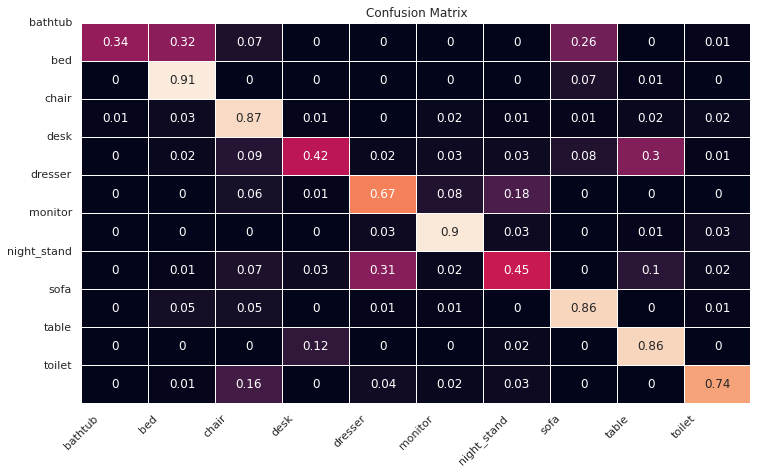

In [22]:
fig=plt.figure(figsize = (12,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)
plt.title("Confusion Matrix")
        

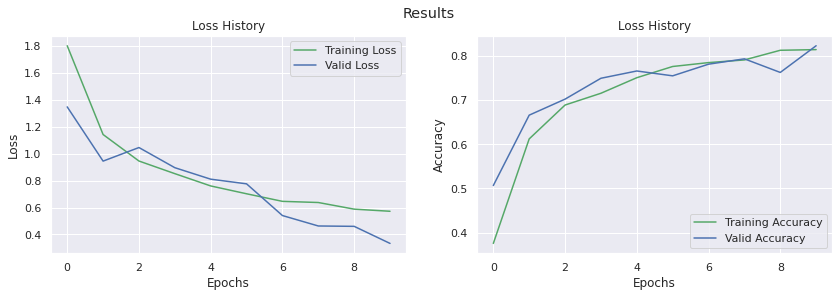

In [23]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
        smoothed_val = w * last + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
        
    return smoothed

eps = range(0, len(history["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Results')
       
ax[0].plot(eps, smooth(history["train_loss"].cpu()), 'g', label='Training Loss')
ax[0].plot(eps, smooth(history["test_loss"].cpu()), 'b', label='Test Loss')
ax[0].set_title('Loss History')
ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].legend()
        
ax[1].plot(eps, smooth(history["train_acc"].cpu()), 'g', label='Training Accuracy')
ax[1].plot(eps, smooth(history["test_acc"].cpu()), 'b', label='Test Accuracy')
ax[1].set_title('Loss History')
ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].legend()